# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

You should produce a Jupyter notebook and a `.txt` file (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

Place your notebook and `.txt` files **only** in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 3 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [62]:
from __future__ import print_function, division
%matplotlib inline

# Your code goes here
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression , LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline



## Description of the dataset
In this assignment our goal is to recognize objects from 19 dierent visual classes (e.g. person, dog, cat, car, ...) in realistic scenes. The dataset consists of several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

Here we will focus on a single classiffication task: you will be required to classify images as to whether or not they contain a person. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. That is, each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 diffeerent visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image). Our dataset with all images is thus a $N \times 500$ dimensional matrix where `N` is the number of images. The resulting representation is much more compact and can be used directly to perform classiffication.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) correspond to the normalized count vector. The last 19 attributes (`is_class`) indicate the presence of at least one object of a particular class in the image. In most of the experiments (unless explicitly noted otherwise) you will be asked to train classiffiers for classifying person vs. non-person images and only the `is_person` attribute and the 500 dimensional feature vector will be used. Do not use the additional class indicator attributes as features unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

*Important: Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 ==========
Load the datasets `train_images_partA.csv` and `valid_images_partA.csv` into two pandas DataFrame called `train_A` and `valid_A`. Display the number of data points and attributes in each of the two datasets.

In [91]:
# Your code goes here
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(data_path, delimiter = ',')
data_path2 = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(data_path2, delimiter = ',')
print(train_A.shape[0])
print(valid_A.shape[0])

2093
1113


### ========== Question 1.2 ==========
Display and inspect the first 10 instances in the training dataset.

In [92]:
# Your code goes here
train_A.head(10)

imgId      dim1      dim2      dim3      dim4      dim5      dim6  \
0  2008_000008  0.002232  0.000558  0.002790  0.000837  0.001674  0.001953   
1  2008_000015  0.001563  0.000391  0.007422  0.003516  0.003906  0.005078   
2  2008_000019  0.000521  0.000000  0.000000  0.001042  0.001563  0.005729   
3  2008_000023  0.002976  0.002232  0.004464  0.000372  0.000372  0.002232   
4  2008_000028  0.001359  0.000340  0.001359  0.000340  0.001359  0.002038   
5  2008_000033  0.000000  0.006324  0.000372  0.000372  0.000372  0.000372   
6  2008_000036  0.000340  0.000000  0.004416  0.000340  0.000679  0.006114   
7  2008_000037  0.000837  0.002232  0.000279  0.000279  0.000837  0.000000   
8  2008_000041  0.002378  0.001359  0.004755  0.001019  0.003736  0.001359   
9  2008_000045  0.001019  0.000340  0.006454  0.001698  0.001359  0.003736   

       dim7      dim8      dim9      ...       is_cow  is_diningtable  is_dog  \
0  0.001395  0.002232  0.003627      ...            0               0       0   
1  0.001953  0.002344  0.001953      ...            0               0       0   
2  0.000521  0.002083  0.003646      ...            0               0       1   
3  0.000000  0.003720  0.000000      ...            0               0       0   
4  0.002378  0.000000  0.003397      ...            0               0       0   
5  0.000744  0.008185  0.000372      ...            0               0       0   
6  0.001359  0.002717  0.003057      ...            0               0       0   
7  0.000279  0.006696  0.000000      ...            0               0       0   
8  0.001019  0.004076  0.003397      ...            0               1       0   
9  0.000000  0.004076  0.000000      ...            0               0       0   

   is_horse  is_motorbike  is_person  is_pottedplant  is_sheep  is_sofa  \
0         1             0          1               0         0        0   
1         0             0          0               0         0        0   
2         0             0          0               0         0        0   
3         0             0          1               0         0        0   
4         0             0          0               0         0        0   
5         0             0          0               0         0        0   
6         0             0          1               0         0        0   
7         0             0          0               0         0        0   
8         0             0          1               0         0        0   
9         0             0          0               0         0        0   

   is_tvmonitor  
0             0  
1             0  
2             0  
3             1  
4             0  
5             0  
6             0  
7             0  
8             0  
9             0  

[10 rows x 520 columns]

### ========== Question 1.3 ==========
In this part we want to select the appopriate attributes (i.e. input features) for training our classifiers. These should be the attributes `dim1, dim2, ..., dim500`. Create a list which has as elements the **names** of the attributes of interest. 

In [93]:
# Your code goes her
train_points = train_A.iloc[:,1:501];
train_targets = train_A.loc[:,'is_person']
valid_points = valid_A.iloc[:,1:501];
valid_targets = valid_A.loc[:,'is_person']
list_targets = train_points.columns
list_targets = list(list_targets)
list_targets

['dim1',
 'dim2',
 'dim3',
 'dim4',
 'dim5',
 'dim6',
 'dim7',
 'dim8',
 'dim9',
 'dim10',
 'dim11',
 'dim12',
 'dim13',
 'dim14',
 'dim15',
 'dim16',
 'dim17',
 'dim18',
 'dim19',
 'dim20',
 'dim21',
 'dim22',
 'dim23',
 'dim24',
 'dim25',
 'dim26',
 'dim27',
 'dim28',
 'dim29',
 'dim30',
 'dim31',
 'dim32',
 'dim33',
 'dim34',
 'dim35',
 'dim36',
 'dim37',
 'dim38',
 'dim39',
 'dim40',
 'dim41',
 'dim42',
 'dim43',
 'dim44',
 'dim45',
 'dim46',
 'dim47',
 'dim48',
 'dim49',
 'dim50',
 'dim51',
 'dim52',
 'dim53',
 'dim54',
 'dim55',
 'dim56',
 'dim57',
 'dim58',
 'dim59',
 'dim60',
 'dim61',
 'dim62',
 'dim63',
 'dim64',
 'dim65',
 'dim66',
 'dim67',
 'dim68',
 'dim69',
 'dim70',
 'dim71',
 'dim72',
 'dim73',
 'dim74',
 'dim75',
 'dim76',
 'dim77',
 'dim78',
 'dim79',
 'dim80',
 'dim81',
 'dim82',
 'dim83',
 'dim84',
 'dim85',
 'dim86',
 'dim87',
 'dim88',
 'dim89',
 'dim90',
 'dim91',
 'dim92',
 'dim93',
 'dim94',
 'dim95',
 'dim96',
 'dim97',
 'dim98',
 'dim99',
 'dim100',
 'dim101

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` and store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets (also make sure you do not include this attribute in your training features). Display the dimensionalities (i.e shapes) of the 4 arrays and make sure your input data are 500-dimensional.

In [94]:
# Your code goes here
X_tr = train_points.values
y_tr = train_targets.values
X_val = valid_points.values
y_val = valid_targets.values
print(X_tr.shape)
print(y_tr.shape)
print(X_val.shape)
print(y_val.shape)

(2093, 500)
(2093,)
(1113, 500)
(1113,)


### ========== Question 1.5 ==========
Show two [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) of the targets in a single plot, one for the training and one for the validation set. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

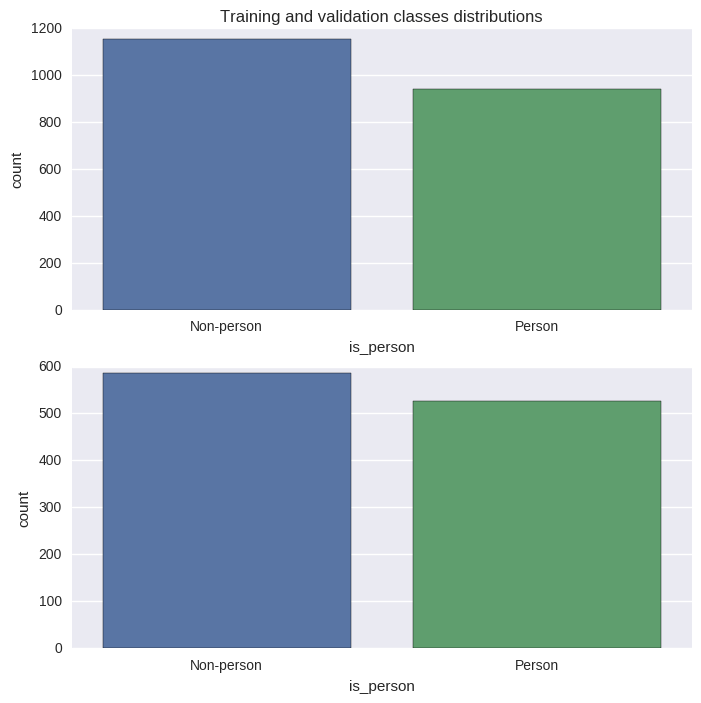

In [95]:
# Your code goes here

figure = plt.figure(figsize=(8,8))
figure.add_subplot(2,1,1)
plt.title("Training and validation classes distributions")
ax1=sns.countplot(x="is_person", data=train_A)
ax1.set_xticklabels(['Non-person','Person']);
figure.add_subplot(2,1,2)
ax2 = sns.countplot(x="is_person", data=valid_A)
ax2.set_xticklabels(['Non-person','Person']);

### ========== Question 1.6 ==========
What would be a good choice for a baseline classifier to compare your results in the next steps against? What classification accuracy score does the baseline classifier achieve in the validation set?

*Your answer goes here*

A choice for a baseline classifier would be to predict the class with the highest prior probability. 

In [96]:
# Your code goes here
print(valid_A["is_person"].value_counts())
print("Performance on the validation set: {}".format(586/(586+527)))

0    586
1    527
Name: is_person, dtype: int64
Performance on the validation set: 0.526504941599


### ========== Question 1.7 ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score in the training and validation sets and compare to that of the baseline classifier. Comment in 1-2 sentences the results. You may include any additional plot(s) if you wish to justify your explanation.

In [97]:
# Your code goes here
logReg = LogisticRegression(solver='lbfgs')
logReg.fit(X_tr, y_tr)
print("Training score {}".format(logReg.score(X_tr,y_tr)))
print("Validation score {}".format(logReg.score(X_val,y_val)))



Training score 0.55088389871
Validation score 0.526504941599


*Your answer goes here*

 The results are the same as the baseline classifier because there is a large penalty for the logistic regression(the LogisticRegression is ridge logistic regression in sklearn). If we change the C value to be sufficiently large enough, the results will be closer to the results in question 1.10 for the scaled data below.

In [98]:
logRegC = LogisticRegression(solver='lbfgs',C=1000000000000)
logRegC.fit(X_tr, y_tr)
print("Training score {}".format(logRegC.score(X_tr,y_tr)))
print("Validation score {}".format(logRegC.score(X_val,y_val)))

Training score 0.759197324415
Validation score 0.680143755615


### ========== Question 1.8 ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [99]:
# Your code goes here
np.set_printoptions(precision=3)
print("Just check means and stds for dim1-5")
train_A.describe()

Just check means and stds for dim1-5


dim1         dim2         dim3         dim4         dim5  \
count  2093.000000  2093.000000  2093.000000  2093.000000  2093.000000   
mean      0.001751     0.000756     0.004317     0.001853     0.002272   
std       0.001193     0.001406     0.003693     0.001340     0.001598   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000833     0.000000     0.001359     0.000756     0.001116   
50%       0.001563     0.000340     0.003397     0.001698     0.002038   
75%       0.002378     0.000893     0.006324     0.002717     0.003057   
max       0.009851     0.016644     0.027514     0.010789     0.010417   

              dim6         dim7         dim8         dim9        dim10  \
count  2093.000000  2093.000000  2093.000000  2093.000000  2093.000000   
mean      0.002220     0.001019     0.002446     0.002088     0.002746   
std       0.001741     0.000873     0.002910     0.001971     0.002328   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.001019     0.000340     0.000625     0.000744     0.001116   
50%       0.001860     0.000744     0.001563     0.001698     0.002056   
75%       0.003057     0.001488     0.003397     0.002717     0.003736   
max       0.021739     0.005774     0.029830     0.028372     0.020380   

           ...            is_cow  is_diningtable       is_dog     is_horse  \
count      ...       2093.000000     2093.000000  2093.000000  2093.000000   
mean       ...          0.017200        0.025323     0.088390     0.045867   
std        ...          0.130048        0.157140     0.283929     0.209247   
min        ...          0.000000        0.000000     0.000000     0.000000   
25%        ...          0.000000        0.000000     0.000000     0.000000   
50%        ...          0.000000        0.000000     0.000000     0.000000   
75%        ...          0.000000        0.000000     0.000000     0.000000   
max        ...          1.000000        1.000000     1.000000     1.000000   

       is_motorbike    is_person  is_pottedplant     is_sheep      is_sofa  \
count   2093.000000  2093.000000     2093.000000  2093.000000  2093.000000   
mean       0.048256     0.449116        0.040134     0.015289     0.032489   
std        0.214358     0.497523        0.196320     0.122729     0.177338   
min        0.000000     0.000000        0.000000     0.000000     0.000000   
25%        0.000000     0.000000        0.000000     0.000000     0.000000   
50%        0.000000     0.000000        0.000000     0.000000     0.000000   
75%        0.000000     1.000000        0.000000     0.000000     0.000000   
max        1.000000     1.000000        1.000000     1.000000     1.000000   

       is_tvmonitor  
count   2093.000000  
mean       0.050167  
std        0.218342  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 519 columns]

### ========== Question 1.9 ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers an [implementation](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Create a standardiser and fit it by using training features only. Then transform both your input and validation input features. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences.

In [100]:
# Your code goes here

standardizer = StandardScaler().fit(X_tr)
X_tr_scaled = standardizer.transform(X_tr)
X_val_scaled = standardizer.transform(X_val)
print("Means for first 5 attributes (training) {}".format(X_tr_scaled.mean(axis=0)[0:5]))
print("When rounding: {} (training)".format(np.around(X_tr_scaled.mean(axis=0)[0:5]),decimals=14))
print("Stds for first 5 attributes {}".format(X_tr_scaled.std(axis=0)[0:5]))
print("All means (training):")
print(X_tr_scaled.mean(axis=0))
print("All stds (training):")
print(X_tr_scaled.std(axis=0))
print("================")
print("Means for first 5 attributes (validation) {}".format(X_val_scaled.mean(axis=0)[0:5]))
print("When rounding: {} (validation)".format(np.around(X_val_scaled.mean(axis=0)[0:5]),decimals=14))
print("Stds for first 5 attributes {}".format(X_val_scaled.std(axis=0)[0:5]))
print("All means (validation):")
print(X_val_scaled.mean(axis=0))
print("All stds (validation):")
print(X_val_scaled.std(axis=0))



Means for first 5 attributes (training) [ -3.395e-17  -2.207e-17   2.444e-16   1.426e-16  -5.771e-17]
When rounding: [-0. -0.  0.  0. -0.] (training)
Stds for first 5 attributes [ 1.  1.  1.  1.  1.]
All means (training):
[ -3.395e-17  -2.207e-17   2.444e-16   1.426e-16  -5.771e-17   5.941e-17
   2.173e-16   1.050e-16  -6.875e-17  -1.018e-16   1.596e-16  -7.638e-17
  -1.443e-17  -2.716e-17  -1.630e-16  -1.018e-17   8.148e-17   3.819e-17
  -1.697e-17   9.845e-17  -1.630e-16   9.336e-18  -5.771e-17   1.052e-16
   1.358e-17  -1.697e-17  -9.506e-17  -1.697e-16   1.647e-16   2.716e-17
   3.395e-18   1.256e-16  -1.867e-17  -2.037e-17   6.790e-18  -1.129e-16
   4.498e-17   4.413e-17  -7.299e-17  -1.409e-16  -2.716e-17   1.765e-16
  -1.035e-16   5.602e-17   5.092e-17  -1.901e-16  -7.469e-17   0.000e+00
   1.591e-16   0.000e+00   1.358e-16  -8.148e-17  -2.801e-17  -4.074e-17
  -5.092e-17  -5.602e-17   1.697e-16  -1.222e-16   1.120e-16   2.886e-17
   1.214e-16  -1.086e-16  -1.867e-17  -6.959e-17

*Your answer goes here*

The results look as expected after rounding of the means(very small numbers). The means are 0 and the variances along each dimensions are 1 and 0 where the value for the dimension is the same for all instances.


### ========== Question 1.10 ==========
By using the transformed input data, retrain a `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy in both the training and validation sets. How does your model compare to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [101]:
# Your code goes here

logReg_scaled = LogisticRegression(solver='lbfgs').fit(X_tr_scaled, y_tr)
print("Training score {}".format(logReg_scaled.score(X_tr_scaled,y_tr)))
print("Validation score {}".format(logReg_scaled.score(X_val_scaled,y_val)))


Training score 0.810797897754
Validation score 0.643306379155


*Your answer goes here*

The results are considerably better for the training set and better for the validation set after the scaling because we're using ridge regression. 

### ========== Question 1.11 ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes for the weight vector. Thus, it helps us prevent overfitting and, for logistic regression, it additionally controls the level of confidence in making predictions.

We would like to optimise this parameter **by using the training dataset only** and not the validation set. Create a 3-fold cross-validation object for the training dataset. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples in each iteration fold.

In [102]:
# Your code goes here

kf3 = KFold(2093, n_folds = 3,shuffle=True, random_state=0)
for train,test in kf3:
    print(len(test))


698
698
697


### ========== Question 1.12 ========== 
Now we want to test out different settings for the regularisation parameter `C` by using the cross-validation iterator from the previous question. For each iteration, we want to train multiple classifiers by using a range of values for `C` and then compute the performance within each CV fold. You should use a log-range for `C` from `1e-5` to `1e5` by using 20 equally-spaced values *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters.

*(hint: your may want to use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [103]:
# Your code goes here

C_values = np.logspace(-5,5,20)
dict_performances = {}

for con in C_values:
    dict_performances[con] = []


for foldnumber,(train,test) in enumerate(kf3,start=1):
    print("Fold {} estimations".format(foldnumber))
    for c in C_values:
        
        train_subset = X_tr_scaled[train,:]
        logRegressor = LogisticRegression(solver = 'lbfgs',C=c).fit(X_tr_scaled[train,:],y_tr[train])
        print("Performance for C = {}: {}".format(c,logRegressor.score(X_tr_scaled[test,:],y_tr[test])))
        dict_performances[c].append(logRegressor.score(X_tr_scaled[test,:],y_tr[test]))
        

                

Fold 1 estimations
Performance for C = 1e-05: 0.573065902579
Performance for C = 3.35981828628e-05: 0.62893982808
Performance for C = 0.000112883789168: 0.667621776504
Performance for C = 0.000379269019073: 0.671919770774
Performance for C = 0.0012742749857: 0.687679083095
Performance for C = 0.00428133239872: 0.696275071633
Performance for C = 0.0143844988829: 0.674785100287
Performance for C = 0.0483293023857: 0.670487106017
Performance for C = 0.162377673919: 0.65329512894
Performance for C = 0.545559478117: 0.659025787966
Performance for C = 1.83298071083: 0.659025787966
Performance for C = 6.15848211066: 0.65329512894
Performance for C = 20.6913808111: 0.64899713467
Performance for C = 69.5192796178: 0.646131805158
Performance for C = 233.572146909: 0.646131805158
Performance for C = 784.759970351: 0.64899713467
Performance for C = 2636.65089873: 0.646131805158
Performance for C = 8858.6679041: 0.646131805158
Performance for C = 29763.5144163: 0.64899713467
Performance for C = 100

In [104]:
for item in dict_performances:
    dict_performances[item] = np.mean(dict_performances[item])
print(dict_performances)

{100000.0: 0.63305831103145005, 0.00037926901907322499: 0.6822615411389239, 1.0000000000000001e-05: 0.55565810082506695, 0.0042813323987193914: 0.71045852123783337, 0.048329302385717518: 0.67176218450200675, 2636.6508987303555: 0.6321032011938188, 8858.6679041008319: 0.6321032011938188, 0.00011288378916846884: 0.66840628207394504, 69.519279617756055: 0.63258075611263453, 6.1584821106602545: 0.63735699045849381, 29763.51441631313: 0.63353586595026579, 0.01438449888287663: 0.68609431332809878, 1.8329807108324339: 0.6411808555975328, 0.0012742749857031334: 0.69898761097841888, 20.691380811147901: 0.63305831103145005, 3.3598182862837813e-05: 0.63210868245544072, 784.75997035146065: 0.63305831103145005, 0.54555947811685146: 0.64643944096612715, 233.57214690901213: 0.63258075611263453, 0.16237767391887209: 0.6569545562302076}


### ========== Question 1.13 ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

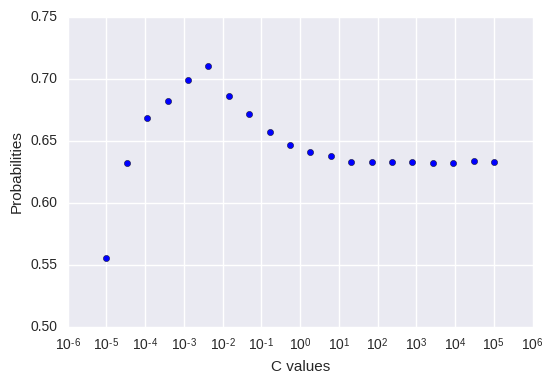

In [105]:
# Your code goes here
ax = plt.subplot(111)
ax.set_xscale('log')
ax.scatter(dict_performances.keys(), dict_performances.values())
plt.xlabel('C values')
plt.ylabel('Probabilities')

plt.show()

### ========== Question 1.14 ==========
Find and display the optimal value for the regularisation parameter `C` of the logistic classifier by using your results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [106]:
# Your code goes here
c_max=max(dict_performances, key=dict_performances.get)
train_subset = X_tr_scaled[train,:]
logRegressor_c = LogisticRegression(solver = 'lbfgs',C=c_max).fit(X_tr_scaled,y_tr)
logRegressor_c.score(X_val_scaled,y_val)


0.69631626235399824

### ========== Question 1.15 ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Can you verify that your results are consistent with those from Question 1.14?

In [107]:
# Your code goes here
lrCV = LogisticRegressionCV(cv=kf3,solver='lbfgs',Cs=C_values)
lrCV.fit(X_tr_scaled,y_tr)
print(lrCV.C_)
print(lrCV.score(X_val_scaled,y_val))
print("Consistent")

[ 0.004]
0.696316262354
Consistent


### ========== Question 1.16 ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 31 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [108]:
# Your code goes here
forrest = RandomForestClassifier(n_estimators=500, criterion='entropy',random_state=31)
forrest.fit(X_tr_scaled,y_tr)
print(forrest.score(X_tr_scaled,y_tr))
print(forrest.score(X_val_scaled,y_val))


1.0
0.698113207547


### ========== Question 1.17 ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

*Your answer goes here*

They're not surprising because because we have a lot of trees and not that many training points in the data set  - 2093. So every point is probably present in a lot of trees which leads to a lot of votes and more votes leads to higher accuracy while the validation set has not been seen yet and every point is not present in a lot of trees which leads to less votes and lower accuracy.


### ========== Question 1.18 ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [109]:
# Your code goes here
names = filter(lambda x: x.startswith('dim'),train_A.columns)
names_importances = zip(names, forrest.feature_importances_)
names_importances.sort(key=lambda x: x[1],reverse=True)
print("50 most important:")
names_importances[0:51]

50 most important:


[('dim21', 0.0071394824583461457),
 ('dim479', 0.0059157375730660312),
 ('dim51', 0.0058824577754376705),
 ('dim360', 0.0056200178513149306),
 ('dim283', 0.0055806334067060306),
 ('dim76', 0.0052695275723760827),
 ('dim4', 0.0048708496987226093),
 ('dim461', 0.0043844148009382303),
 ('dim274', 0.0043304905583058488),
 ('dim330', 0.0042984719662352401),
 ('dim263', 0.0042655409982488368),
 ('dim343', 0.0041855943544299766),
 ('dim348', 0.0041831422411554055),
 ('dim217', 0.004155516242685499),
 ('dim222', 0.0041426955267592639),
 ('dim347', 0.0040604491323804467),
 ('dim74', 0.004052828850698722),
 ('dim356', 0.0040450870154244882),
 ('dim398', 0.0039972349286131886),
 ('dim423', 0.0038890974014359207),
 ('dim500', 0.0037081744222333458),
 ('dim73', 0.0036919154848592171),
 ('dim485', 0.0036215294757366307),
 ('dim214', 0.0036163458536278351),
 ('dim326', 0.0036002585546417868),
 ('dim254', 0.0035988152794292779),
 ('dim483', 0.0035952745745134419),
 ('dim92', 0.0035335683966167806),
 (

### ========== Question 1.19 ==========
Next, we would like to test out the performance of support vector classification and experiment with different kernels. 
By using training data only and default parameter settings, train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [110]:
# Your code goes here
svc_lin = SVC(kernel = 'linear')
svc_lin.fit(X_tr_scaled, y_tr)
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_tr_scaled, y_tr)
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_tr_scaled, y_tr)

print('Linear SVC classification accuracy on training set: {:.3f}'.format(svc_lin.score(X_tr_scaled, y_tr)))
print('Linear SVC classification accuracy on validation set: {:.3f}'.format(svc_lin.score(X_val_scaled, y_val)))
print("=============================")
print('RBF SVC classification accuracy on training set: {:.3f}'.format(svc_rbf.score(X_tr_scaled, y_tr)))
print('RBF SVC classification accuracy on validation set: {:.3f}'.format(svc_rbf.score(X_val_scaled, y_val)))
print("=============================")
print('Poly SVC classification accuracy on training set: {:.3f}'.format(svc_poly.score(X_tr_scaled, y_tr)))
print('Poly SVC classification accuracy on test set: {:.3f}'.format(svc_poly.score(X_val_scaled, y_val)))

Linear SVC classification accuracy on training set: 0.842
Linear SVC classification accuracy on validation set: 0.639
RBF SVC classification accuracy on training set: 0.911
RBF SVC classification accuracy on validation set: 0.730
Poly SVC classification accuracy on training set: 0.991
Poly SVC classification accuracy on test set: 0.702


### ========== Question 1.20 ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the results by using 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [111]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

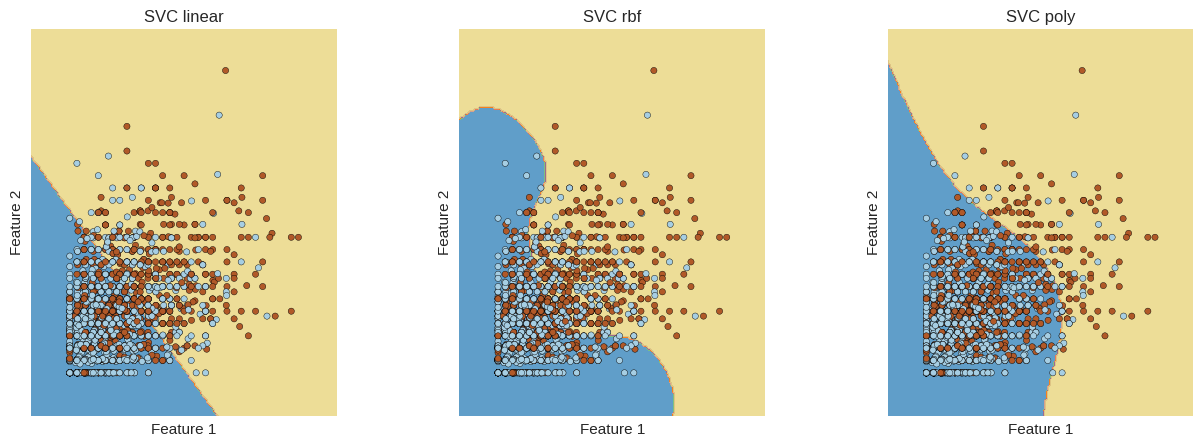

In [112]:
# Your code goes here
two_d_input = X_tr_scaled[:,[20,75]]

svc_lin2d = SVC(kernel = 'linear')
svc_lin2d.fit(two_d_input, y_tr)
svc_rbf2d = SVC(kernel='rbf')
svc_rbf2d.fit(two_d_input, y_tr)
svc_poly2d = SVC(kernel='poly')
svc_poly2d.fit(two_d_input, y_tr)

clfs = [svc_lin2d, svc_rbf2d, svc_poly2d]

show_svc_decision_boundaries(clfs, two_d_input, title=["SVC linear", "SVC rbf", "SVC poly"])


*Your answer goes here*

Eyeballing the regions, the separation is not perfect, but I would assume that the SVM rbf performs best in this 2d case. Where the brown data points become more dense, the yellow region goes deeper into the blue region and the rbf catches some pecululiarities of the training data such as the blue points to the bottom right of the blue region and to the top of the blue region. I think the SVC polynomial favors the blue class too much and the linear model doesn't capture any patterns of the data.


### ========== Question 1.21 ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

Fold 1 estimations
Performance for C = 0.01: 0.560171919771
Performance for C = 0.035938136638: 0.583094555874
Performance for C = 0.129154966501: 0.671919770774
Performance for C = 0.464158883361: 0.702005730659
Performance for C = 1.6681005372: 0.713467048711
Performance for C = 5.99484250319: 0.709169054441
Performance for C = 21.5443469003: 0.709169054441
Performance for C = 77.4263682681: 0.709169054441
Performance for C = 278.255940221: 0.709169054441
Performance for C = 1000.0: 0.709169054441
Fold 2 estimations
Performance for C = 0.01: 0.545845272206
Performance for C = 0.035938136638: 0.545845272206
Performance for C = 0.129154966501: 0.69770773639
Performance for C = 0.464158883361: 0.73782234957
Performance for C = 1.6681005372: 0.739255014327
Performance for C = 5.99484250319: 0.713467048711
Performance for C = 21.5443469003: 0.713467048711
Performance for C = 77.4263682681: 0.713467048711
Performance for C = 278.255940221: 0.713467048711
Performance for C = 1000.0: 0.71346

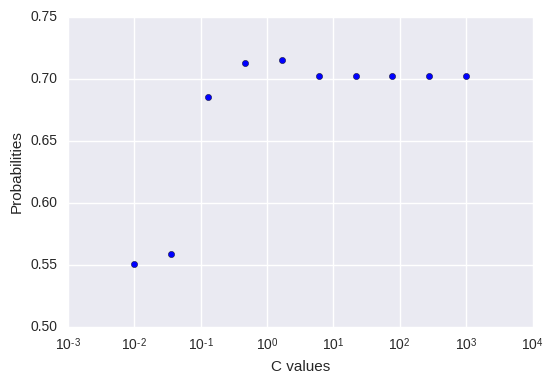

In [113]:
# Your code goes here
C_values_svm = np.logspace(-2, 3, 10)

dict_performances_svm = {}

for cons in C_values_svm:
    dict_performances_svm[cons] = []


for foldnumber,(train,test) in enumerate(kf3,start=1):
    print("Fold {} estimations".format(foldnumber))
    for c in C_values_svm:
        
        train_subset = X_tr_scaled[train,:]
        svmRbf = SVC(kernel = 'rbf',C=c,gamma = 'auto').fit(X_tr_scaled[train,:],y_tr[train])
        print("Performance for C = {}: {}".format(c,svmRbf.score(X_tr_scaled[test,:],y_tr[test])))
        dict_performances_svm[c].append(svmRbf.score(X_tr_scaled[test,:],y_tr[test]))

for item in dict_performances_svm:
    dict_performances_svm[item] = np.mean(dict_performances_svm[item])
    
print("===============")
print("Dictionary of c's with means for the clusters: {}".format(dict_performances_svm))
print("================-")

ax3 = plt.subplot(111)
ax3.set_xscale('log')
plt.xlabel('C values')
plt.ylabel('Probabilities')
ax3.scatter(dict_performances_svm.keys(), dict_performances_svm.values())

c_max_svm=max(dict_performances_svm, key=dict_performances_svm.get)

print("C that yields maximum mean: {}".format(c_max_svm))

svc_c_max = SVC(kernel='rbf', C=c_max_svm).fit(X_tr_scaled,y_tr)
print("Training accuracy: {}".format(svc_c_max.score(X_tr_scaled,y_tr)))
print("Validation accuracy: {}".format(svc_c_max.score(X_val_scaled,y_val)))

### ========== Question 1.22 ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

Fold 1 estimations
Performance for Gamma = 1e-05: 0.561604584527
Performance for Gamma = 3.5938136638e-05: 0.661891117479
Performance for Gamma = 0.000129154966501: 0.671919770774
Performance for Gamma = 0.000464158883361: 0.704871060172
Performance for Gamma = 0.0016681005372: 0.713467048711
Performance for Gamma = 0.00599484250319: 0.710601719198
Performance for Gamma = 0.0215443469003: 0.560171919771
Performance for Gamma = 0.0774263682681: 0.560171919771
Performance for Gamma = 0.278255940221: 0.560171919771
Performance for Gamma = 1.0: 0.560171919771
Fold 2 estimations
Performance for Gamma = 1e-05: 0.545845272206
Performance for Gamma = 3.5938136638e-05: 0.659025787966
Performance for Gamma = 0.000129154966501: 0.710601719198
Performance for Gamma = 0.000464158883361: 0.744985673352
Performance for Gamma = 0.0016681005372: 0.74212034384
Performance for Gamma = 0.00599484250319: 0.723495702006
Performance for Gamma = 0.0215443469003: 0.545845272206
Performance for Gamma = 0.077426

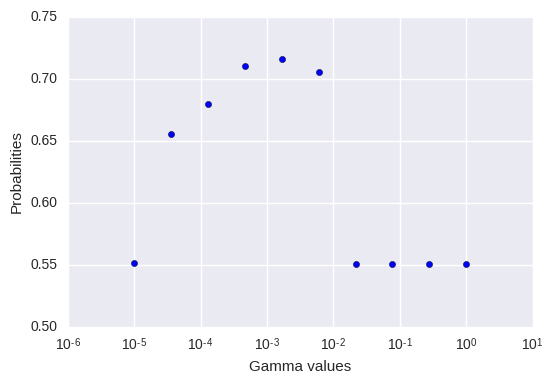

In [114]:
# Your code goes here

gamma_values_svm = np.logspace(-5, 0, 10)

dict_performances_svm_gamma = {}

for cons in gamma_values_svm:
    dict_performances_svm_gamma[cons] = []


for foldnumber,(train,test) in enumerate(kf3,start=1):
    print("Fold {} estimations".format(foldnumber))
    for g in gamma_values_svm:
        
        train_subset = X_tr_scaled[train,:]
        svmRbf_gamma = SVC(kernel = 'rbf',C=1,gamma = g).fit(X_tr_scaled[train,:],y_tr[train])
        print("Performance for Gamma = {}: {}".format(g,svmRbf_gamma.score(X_tr_scaled[test,:],y_tr[test])))
        dict_performances_svm_gamma[g].append(svmRbf_gamma.score(X_tr_scaled[test,:],y_tr[test]))

for item in dict_performances_svm_gamma:
    dict_performances_svm_gamma[item] = np.mean(dict_performances_svm_gamma[item])
    
print("===============")
print("Dictionary of gammas with means for the clusters: {}".format(dict_performances_svm_gamma))
print("================-")

ax5 = plt.subplot(111)
ax5.set_xscale('log')
plt.xlabel('Gamma values')
plt.ylabel('Probabilities')
ax5.scatter(dict_performances_svm_gamma.keys(), dict_performances_svm_gamma.values())

gamma_max_svm=max(dict_performances_svm_gamma, key=dict_performances_svm_gamma.get)

print("Gamma that yields maximum mean: {}".format(gamma_max_svm))

svc_gamma_max = SVC(kernel='rbf', C=1, gamma = gamma_max_svm).fit(X_tr_scaled,y_tr)
print("Training accuracy: {}".format(svc_gamma_max.score(X_tr_scaled,y_tr)))
print("Validation accuracy: {}".format(svc_gamma_max.score(X_val_scaled,y_val)))




### ========== Question 1.23 ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

Fold 0 estimations
Performance for Gamma,C = 0.0001,0.01: 0.560171919771
Performance for Gamma,C = 0.0001,0.1: 0.560171919771
Performance for Gamma,C = 0.0001,1.0: 0.67335243553
Performance for Gamma,C = 0.0001,10.0: 0.699140401146
Performance for Gamma,C = 0.001,0.01: 0.560171919771
Performance for Gamma,C = 0.001,0.1: 0.676217765043
Performance for Gamma,C = 0.001,1.0: 0.707736389685
Performance for Gamma,C = 0.001,10.0: 0.691977077364
Performance for Gamma,C = 0.01,0.01: 0.560171919771
Performance for Gamma,C = 0.01,0.1: 0.560171919771
Performance for Gamma,C = 0.01,1.0: 0.657593123209
Performance for Gamma,C = 0.01,10.0: 0.670487106017
Performance for Gamma,C = 0.1,0.01: 0.560171919771
Performance for Gamma,C = 0.1,0.1: 0.560171919771
Performance for Gamma,C = 0.1,1.0: 0.560171919771
Performance for Gamma,C = 0.1,10.0: 0.560171919771
Fold 1 estimations
Performance for Gamma,C = 0.0001,0.01: 0.545845272206
Performance for Gamma,C = 0.0001,0.1: 0.545845272206
Performance for Gamma,C 

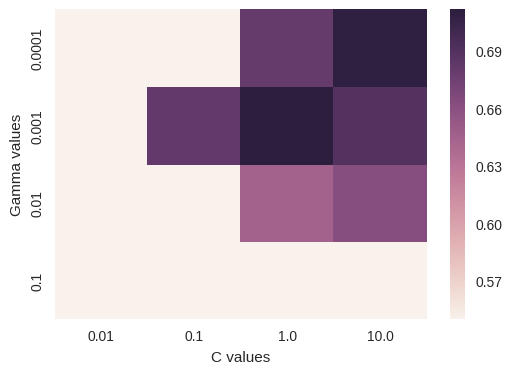

In [116]:
# Your code goes here 

# Code continues in cells below

C_values2 = np.logspace(-2, 1, 4)
gammas2 = np.logspace(-4, -1, 4)
two_d_map_matrix = np.zeros((4,4,3))
two_d_means = np.zeros((4,4))

for foldnumber,(train,test) in enumerate(kf3,start=0):
    print("Fold {} estimations".format(foldnumber))
    for id_g,gam in enumerate(gammas2):
        for id_c, c_val in enumerate(C_values2):
        
            train_subset = X_tr_scaled[train,:]
            svmRbf_gamma_c = SVC(kernel = 'rbf',C=c_val,gamma = gam).fit(X_tr_scaled[train,:],y_tr[train])
            print("Performance for Gamma,C = {},{}: {}".format(gam,c_val,svmRbf_gamma_c.score(X_tr_scaled[test,:],y_tr[test])))
            two_d_map_matrix[id_g][id_c][foldnumber] = (svmRbf_gamma_c.score(X_tr_scaled[test,:],y_tr[test]))


two_d_first_fold = two_d_map_matrix[:,:,0]
two_d_snd_fold = two_d_map_matrix[:,:,1]
two_d_thrd_fold = two_d_map_matrix[:,:,2]

for row in range(0,4):
    for col in range(0,4):
        two_d_means[row][col] = np.mean([two_d_first_fold[row][col],two_d_snd_fold[row][col],two_d_thrd_fold[row][col]])
        
print(two_d_means)


sns.heatmap(two_d_means,xticklabels=C_values2 , yticklabels=gammas2)
plt.xlabel('C values')
plt.ylabel('Gamma values')
# Code continues in cell below

In [117]:
svmRbf_gamma_c_max = SVC(kernel = 'rbf',C=1,gamma = 0.001).fit(X_tr_scaled,y_tr)
print("Training set accuracy: {}".format(svmRbf_gamma_c_max.score(X_tr_scaled,y_tr)))
print("Validation set accuracy: {}".format(svmRbf_gamma_c_max.score(X_val_scaled,y_val)))

Training set accuracy: 0.834687052078
Validation set accuracy: 0.721473495058


### ========== Question 1.24 ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

*Your answer goes here*

The score is not better because we shrinked and changed the independent search spaces of the gamma and the C parameters. We searched more gamma values in 1.22 and more C values in 1.21 (and in different ranges). Moreover - C and gamma aren't independent and even if we didn't shrink the search spaces, and picked the parameters that maximized the classifier performance separately(keeping one of them fixed at a time), this doesn't mean that they'll maximize and give even better performance together. 
A solution for this would be to search wider ranges of gammas and C values, but the associated problem would be the computational cost.

### ========== Question 1.25 ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

Fold 1 estimations
Performance for degree = 1: 0.679083094556
Performance for degree = 2: 0.674785100287
Performance for degree = 3: 0.654727793696
Performance for degree = 4: 0.613180515759
Performance for degree = 5: 0.631805157593
Performance for degree = 6: 0.583094555874
Performance for degree = 7: 0.557306590258
Fold 2 estimations
Performance for degree = 1: 0.744985673352
Performance for degree = 2: 0.679083094556
Performance for degree = 3: 0.710601719198
Performance for degree = 4: 0.60888252149
Performance for degree = 5: 0.583094555874
Performance for degree = 6: 0.560171919771
Performance for degree = 7: 0.554441260745
Fold 3 estimations
Performance for degree = 1: 0.684361549498
Performance for degree = 2: 0.641319942611
Performance for degree = 3: 0.687230989957
Performance for degree = 4: 0.661406025825
Performance for degree = 5: 0.601147776184
Performance for degree = 6: 0.57962697274
Performance for degree = 7: 0.572453371593
Dictionary of c's with means for the clust

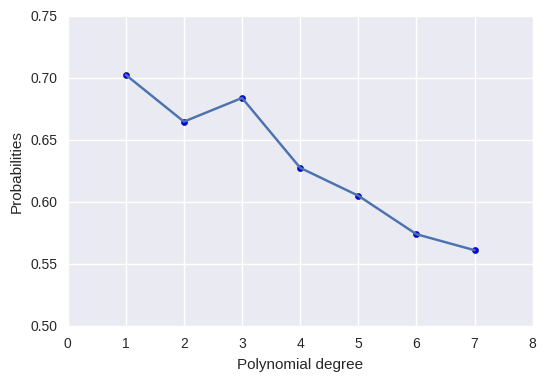

Degree that yields maximum mean: 1
Training accuracy: 0.990922121357
Validation accuracy: 0.701707097934


In [118]:
# Your code goes here

degrees_svm = np.arange(1,8)

dict_performances_svm_deg = {}

for cons in degrees_svm:
    dict_performances_svm_deg[cons] = []


for foldnumber,(train,test) in enumerate(kf3,start=1):
    print("Fold {} estimations".format(foldnumber))
    for deg in degrees_svm:
        
        train_subset = X_tr_scaled[train,:]
        svmPoly_deg = SVC(kernel = 'poly',degree=deg).fit(X_tr_scaled[train,:],y_tr[train])
        print("Performance for degree = {}: {}".format(deg,svmPoly_deg.score(X_tr_scaled[test,:],y_tr[test])))
        dict_performances_svm_deg[deg].append(svmPoly_deg.score(X_tr_scaled[test,:],y_tr[test]))

for item in dict_performances_svm_deg:
    dict_performances_svm_deg[item] = np.mean(dict_performances_svm_deg[item])
    
print("===============")
print("Dictionary of c's with means for the clusters: {}".format(dict_performances_svm))
print("================-")

ax8 = plt.subplot(111)

plt.xlabel('Polynomial degree')
plt.ylabel('Probabilities')

#ax8.set_xscale('log')
ax8.scatter(dict_performances_svm_deg.keys(), dict_performances_svm_deg.values())
ax8.plot(dict_performances_svm_deg.keys(), dict_performances_svm_deg.values())
plt.show()


deg_max_svm=max(dict_performances_svm_deg, key=dict_performances_svm_deg.get)

print("Degree that yields maximum mean: {}".format(deg_max_svm))

svc_deg_max = SVC(kernel='poly', C=deg_max_svm).fit(X_tr_scaled,y_tr)
print("Training accuracy: {}".format(svc_deg_max.score(X_tr_scaled,y_tr)))
print("Validation accuracy: {}".format(svc_deg_max.score(X_val_scaled,y_val)))

### ========== Question 1.26 ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

*Your answer goes here*

I think it is a bad idea, because we're using the same set to train and test the data. Even though on each iteration of the cross validaiton we're using different training/test set, there are overlaps of the training/test sets over all iterations so we're overfitting on the training set. The approach is good in case we don't have enough data to split our instances into training/validation/test set. In practice I think it would be better to train all combinations of parameters on the testing set and then estimate the generalization error using the validation set for all combinations and choose the best parameters for the validation set.



### ========== Question 1.27 ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [119]:
# Your code goes here
train_A_noID = train_A.drop('imgId',axis=1)
X_tr_all_indicators = train_A_noID.drop('is_person',axis=1).as_matrix()
valid_A_noID = valid_A.drop('imgId', axis=1)
X_val_all_indicators = valid_A_noID.drop('is_person',axis=1).as_matrix()
standardizer_all_ind = StandardScaler().fit(X_tr_all_indicators)
X_tr_scaled_all_ind = standardizer_all_ind.transform(X_tr_all_indicators)
X_val_scaled_all_ind = standardizer_all_ind.transform(X_val_all_indicators)
forrest_all_ind = RandomForestClassifier(n_estimators=500,criterion='entropy',random_state=31).fit(X_tr_scaled_all_ind,y_tr)
print("Training accuracy: {}".format(forrest_all_ind.score(X_tr_scaled_all_ind,y_tr)))
print("Validation accuracy: {}".format(forrest_all_ind.score(X_val_scaled_all_ind,y_val)))


Training accuracy: 1.0
Validation accuracy: 0.711590296496


In [36]:
names_noperson = filter(lambda x: x.startswith('dim'),train_A_noID.drop('is_person',axis=1).columns)
names_importances_noperson = zip(names_noperson, forrest_all_ind.feature_importances_)
names_importances_noperson.sort(key=lambda x: x[1],reverse=True)
print("50 most important:")
names_importances_noperson[0:51]

50 most important:


[('dim21', 0.008030268242118669),
 ('dim51', 0.0059245937795918318),
 ('dim360', 0.005463270730147453),
 ('dim4', 0.0053254635730240014),
 ('dim76', 0.0052711094276990432),
 ('dim398', 0.0052542912934713882),
 ('dim283', 0.0049825214687269567),
 ('dim479', 0.0049417709169217588),
 ('dim263', 0.0047338405389478009),
 ('dim343', 0.0046091911270877816),
 ('dim423', 0.0044332941459177136),
 ('dim485', 0.0042446900093632139),
 ('dim254', 0.004188582305401224),
 ('dim461', 0.0041575039787235292),
 ('dim222', 0.0041343771358179392),
 ('dim356', 0.0039138875860249295),
 ('dim74', 0.0038603367481714335),
 ('dim288', 0.0038503656836912049),
 ('dim214', 0.0037915869326592007),
 ('dim348', 0.0037810959049539117),
 ('dim330', 0.003712548531421811),
 ('dim217', 0.0036834267865541752),
 ('dim483', 0.0036327747075583202),
 ('dim90', 0.0036258903666367714),
 ('dim274', 0.0035970303119618125),
 ('dim347', 0.0035330997133573776),
 ('dim17', 0.0034476083156718068),
 ('dim427', 0.0033773881272774462),
 ('d

*Your answer goes here*

I observe that the most significant features are generally the same, but not in the same order for both classifiers(because of the randomness of the algorithm).

The results are better by a couple percent but the features that are most important for defining a person still remain the same. The results are better because there may be a tendency for certain kind of objects to be present in the pictures with a person more often than others. However, there is no significant pattern. The additional information is useful but:

1: During the collection of data we have to look at different kind of objects - not just if a person is in the picture or not.

2: I'm not sure how using more dimensions influences the random forrest algorithm in terms of speed/memory but that could be a factor as well.

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classiffier you like (with the provison that you can explain what the classiffier/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the posterior probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated posterior probabilities for the data points in the test set into a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. You are then required to copy this file into your submission folder along with your notebook (see Mecanics section at the top of the notebook) and then submit the two files by using the `submit` command on DICE. You are only required to use the `submit` command once.

In [6]:
# Your code goes here

data_path3 = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
train_B = pd.read_csv(data_path3, delimiter = ',')
data_path4 = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
valid_B = pd.read_csv(data_path4, delimiter = ',')
data_path5 = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
test_B = pd.read_csv(data_path5, delimiter = ',')


In [7]:
train_points_B = train_B.iloc[:,1:501];
train_targets_B = train_B.loc[:,'is_person']
valid_points_B = valid_B.iloc[:,1:501];
valid_targets_B = valid_B.loc[:,'is_person']
test_points_B = test_B.iloc[:,0:500];

In [8]:
X_tr_B = train_points_B.values
y_tr_B = train_targets_B.values
X_val_B = valid_points_B.values
y_val_B = valid_targets_B.values
X_test_B = test_points_B.values

In [9]:
standardizer_B = StandardScaler().fit(X_tr_B)
X_tr_scaled_B = standardizer_B.transform(X_tr_B)
X_val_scaled_B = standardizer_B.transform(X_val_B)
X_test_scaled_B = standardizer_B.transform(X_test_B)

In [10]:
gamma_values_svm_B = np.logspace(-5, 0, 10)
C_values_svm_B = np.logspace(-2, 3, 10)

In [11]:
for id_g,gam in enumerate(gamma_values_svm_B):
    for id_c, c_val in enumerate(C_values_svm_B):
        svmRbf_gamma_c_B = SVC(kernel = 'rbf',C=c_val,gamma = gam,probability=True).fit(X_tr_scaled_B,y_tr_B)
        print("Performance for Gamma,C = {},{}: {}".format(gam,c_val,svmRbf_gamma_c_B.score(X_val_scaled_B,y_val_B)))
        


Performance for Gamma,C = 1e-05,0.01: 0.526504941599
Performance for Gamma,C = 1e-05,0.035938136638: 0.526504941599
Performance for Gamma,C = 1e-05,0.129154966501: 0.526504941599
Performance for Gamma,C = 1e-05,0.464158883361: 0.526504941599
Performance for Gamma,C = 1e-05,1.6681005372: 0.526504941599
Performance for Gamma,C = 1e-05,5.99484250319: 0.526504941599
Performance for Gamma,C = 1e-05,21.5443469003: 0.526504941599
Performance for Gamma,C = 1e-05,77.4263682681: 0.526504941599
Performance for Gamma,C = 1e-05,278.255940221: 0.526504941599
Performance for Gamma,C = 1e-05,1000.0: 0.526504941599
Performance for Gamma,C = 3.5938136638e-05,0.01: 0.526504941599
Performance for Gamma,C = 3.5938136638e-05,0.035938136638: 0.526504941599
Performance for Gamma,C = 3.5938136638e-05,0.129154966501: 0.526504941599
Performance for Gamma,C = 3.5938136638e-05,0.464158883361: 0.526504941599
Performance for Gamma,C = 3.5938136638e-05,1.6681005372: 0.526504941599
Performance for Gamma,C = 3.59381366

In [12]:
svmRbf_gamma_c_B = SVC(kernel = 'rbf',C=77.4263682681,gamma = 0.278255940221,probability=True).fit(X_tr_scaled_B,y_tr_B)
pred_proba = svmRbf_gamma_c_B.predict_proba(X_val_scaled_B)
this_logloss = log_loss(y_val_B, pred_proba)

In [121]:
pred_proba

array([[ 0.41407896,  0.58592104],
       [ 0.84661756,  0.15338244],
       [ 0.51636824,  0.48363176],
       [ 0.61051061,  0.38948939],
       [ 0.45035791,  0.54964209],
       [ 0.23936392,  0.76063608],
       [ 0.21275305,  0.78724695],
       [ 0.44420982,  0.55579018],
       [ 0.29206696,  0.70793304],
       [ 0.72053415,  0.27946585],
       [ 0.78328397,  0.21671603],
       [ 0.20803582,  0.79196418],
       [ 0.81425589,  0.18574411],
       [ 0.59195664,  0.40804336],
       [ 0.83234593,  0.16765407],
       [ 0.32699899,  0.67300101],
       [ 0.54882984,  0.45117016],
       [ 0.89036865,  0.10963135],
       [ 0.44969187,  0.55030813],
       [ 0.45272361,  0.54727639],
       [ 0.05111675,  0.94888325],
       [ 0.36467114,  0.63532886],
       [ 0.8380735 ,  0.1619265 ],
       [ 0.23636829,  0.76363171],
       [ 0.18988166,  0.81011834],
       [ 0.22776758,  0.77223242],
       [ 0.39198673,  0.60801327],
       [ 0.53485855,  0.46514145],
       [ 0.56006172,

In [17]:
this_logloss

0.58666842681716691

In [51]:
degrees_svm_B = np.arange(1,8)

for deg in degrees_svm_B:
    svmPoly_deg = SVC(kernel = 'poly',degree=deg).fit(X_tr_scaled_B,y_tr_B)
    print("Performance for degree = {}: {}".format(deg,svmPoly_deg.score(X_val_scaled_B,y_val_B)))
    

Performance for degree = 1: 0.526504941599
Performance for degree = 2: 0.526504941599
Performance for degree = 3: 0.526504941599
Performance for degree = 4: 0.526504941599
Performance for degree = 5: 0.526504941599
Performance for degree = 6: 0.526504941599
Performance for degree = 7: 0.526504941599


In [32]:
print("Polynomial svm not performing well - may be something regarding the scaling of the data.")

Polynomial svm not performing well - may be something regarding the scaling of the data.


In [29]:
C_values_lr = np.logspace(-5,5,20)


for c in C_values_lr:

    logRegressor = LogisticRegression(solver = 'lbfgs',C=c).fit(X_tr_scaled_B,y_tr_B)
    print("Performance for C = {}: {}".format(c,logRegressor.score(X_val_scaled_B,y_val_B)))
        


Performance for C = 1e-05: 0.526504941599
Performance for C = 3.35981828628e-05: 0.526504941599
Performance for C = 0.000112883789168: 0.526504941599
Performance for C = 0.000379269019073: 0.526504941599
Performance for C = 0.0012742749857: 0.526504941599
Performance for C = 0.00428133239872: 0.526504941599
Performance for C = 0.0143844988829: 0.526504941599
Performance for C = 0.0483293023857: 0.526504941599
Performance for C = 0.162377673919: 0.526504941599
Performance for C = 0.545559478117: 0.533692722372
Performance for C = 1.83298071083: 0.641509433962
Performance for C = 6.15848211066: 0.67115902965
Performance for C = 20.6913808111: 0.674752920036
Performance for C = 69.5192796178: 0.682839173405
Performance for C = 233.572146909: 0.680143755615
Performance for C = 784.759970351: 0.687331536388
Performance for C = 2636.65089873: 0.688230008985
Performance for C = 8858.6679041: 0.687331536388
Performance for C = 29763.5144163: 0.681940700809
Performance for C = 100000.0: 0.68373

In [40]:
num_trees = np.arange(250,750,50)
for i in num_trees:
    forrestReg = RandomForestClassifier(criterion='entropy',n_estimators=i).fit(X_tr_scaled_B,y_tr_B)
    print("Performance for num_trees = {}: {}".format(i,logRegressor.score(X_val_scaled_B,y_val_B)))

Performance for num_trees = 250: 0.683737646002
Performance for num_trees = 300: 0.683737646002
Performance for num_trees = 350: 0.683737646002
Performance for num_trees = 400: 0.683737646002
Performance for num_trees = 450: 0.683737646002
Performance for num_trees = 500: 0.683737646002
Performance for num_trees = 550: 0.683737646002
Performance for num_trees = 600: 0.683737646002
Performance for num_trees = 650: 0.683737646002
Performance for num_trees = 700: 0.683737646002


In [45]:
C_values_svm_lin_B = np.logspace(-2, 3, 10)

for valC in C_values_svm_lin_B:
    svc_lin_B_0 = SVC(kernel='linear',C=valC).fit(X_tr_scaled_B,y_tr_B)
    print("Performance for C = {}: {}".format(valC,svc_lin_B_0.score(X_val_scaled_B,y_val_B)))


Performance for C = 0.01: 0.526504941599
Performance for C = 0.035938136638: 0.526504941599
Performance for C = 0.129154966501: 0.526504941599
Performance for C = 0.464158883361: 0.526504941599
Performance for C = 1.6681005372: 0.534591194969
Performance for C = 5.99484250319: 0.666666666667
Performance for C = 21.5443469003: 0.684636118598
Performance for C = 77.4263682681: 0.689128481581
Performance for C = 278.255940221: 0.680143755615
Performance for C = 1000.0: 0.66576819407


In [63]:
# From lab 4:
k_list = [5, 10, 50, 100, 200, 500, 1000, 1500, 2000]
logloss = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_tr_scaled_B, y_tr_B)
    print('Performance on test with ', k, ' nearest neighbours: ', knn.score(X_val_scaled_B,y_val_B))

Performance on test with  5  nearest neighbours:  0.629829290207
Performance on test with  10  nearest neighbours:  0.672955974843
Performance on test with  50  nearest neighbours:  0.63432165319
Performance on test with  100  nearest neighbours:  0.638814016173
Performance on test with  200  nearest neighbours:  0.619946091644
Performance on test with  500  nearest neighbours:  0.58939802336
Performance on test with  1000  nearest neighbours:  0.547169811321
Performance on test with  1500  nearest neighbours:  0.569631626235
Performance on test with  2000  nearest neighbours:  0.526504941599


In [106]:
# I'll try with a voting ensemble as well. http://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/

logReg_B = LogisticRegression(solver='lbfgs',C = 2636.65089873)
svmPoly_B = SVC(kernel = 'poly', degree=2,probability=True)
svmRBF_B = SVC(kernel = 'rbf',C=1.0,gamma = 21.5443469003,probability=True)
rfc_B = RandomForestClassifier(criterion='entropy',n_estimators=500)
svc_lin_B = SVC(kernel = 'linear',probability=True)
knn = KNeighborsClassifier(n_neighbors=10)

# This is for adjusting weights
#logReg - max 68.8
#svmpoly - max 50
#svmrbf - max 69.99
#forrest - max 68.3
#svmlin - max 68.9
#knn - max 0.672955974843

estimators = [('logReg',logReg_B),('svmPoly',svmPoly_B),('svmRbf',svmRBF_B),('randF',rfc_B),('svcLin',svc_lin_B),('knn',knn)]
voter = VotingClassifier(estimators)
voter.fit(X_tr_scaled_B,y_tr_B)
voter.score(X_val_scaled_B,y_val_B)

# weights = [2,1,2.2,1.8,2.1,1.5]

0.70979335130278531

In [74]:
np.set_printoptions(threshold=np.nan)

In [78]:
print("The voter I'm using has vote = 'hard' and I can't use the voter.predict_proba (the vote must be soft, but with soft vote the accuracy drops significantly) so I'm going to count the probabilities by hand and put them in an array")

The voter I'm using has vote = 'hard' and I can't use the voter.predict_proba (the vote must be soft, but with soft vote the accuracy drops significantly) so I'm going to count the probabilities by hand and put them in an array


In [107]:
print("We'll extract the log loss for the validation set, then for the test set.")

We'll extract the log loss for the validation set, then for the test set.


In [108]:
votes_val = voter.transform(X_val_scaled_B)

In [119]:
# We'll extract the probabilities

votes_val.shape
votes_val_probs = np.zeros((1113,2))

for i in range(0,1113):
    for j in range(0,6):
        if votes_val[i,j] == 0:
            votes_val_probs[i,0] += 1
        else:
            votes_val_probs[i,1] += 1
            
    votes_val_probs[i,0] = votes_val_probs[i,0]/6
    votes_val_probs[i,1] = votes_val_probs[i,1]/6
    
votes_val_probs

array([[ 0.33333333,  0.66666667],
       [ 0.83333333,  0.16666667],
       [ 0.66666667,  0.33333333],
       [ 1.        ,  0.        ],
       [ 0.5       ,  0.5       ],
       [ 0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667],
       [ 0.5       ,  0.5       ],
       [ 0.33333333,  0.66666667],
       [ 0.83333333,  0.16666667],
       [ 1.        ,  0.        ],
       [ 0.33333333,  0.66666667],
       [ 1.        ,  0.        ],
       [ 0.83333333,  0.16666667],
       [ 1.        ,  0.        ],
       [ 0.33333333,  0.66666667],
       [ 0.83333333,  0.16666667],
       [ 1.        ,  0.        ],
       [ 0.5       ,  0.5       ],
       [ 0.5       ,  0.5       ],
       [ 0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667],
       [ 1.        ,  0.        ],
       [ 0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667],
       [ 0.83333333,

In [120]:
log_loss(y_val_B,votes_val_probs)

3.4581671585371923

In [131]:
print("IMPORTANT! The log loss is quite high. Even though we're right more often, we're also confident more often which leads to increase in this error metric. I'm going to use the error metric from this classifier but if it's going to bring me more marks, please export the pred_proba array from the standalone svm RBF classifier in the beginning of part B (Ctrl+F pred_proba (one arrow above def safe_predictions and this print statement)) with logloss 0.58 for the validation set. This should be my job but I like the voter classifier because of the higher accuracy but in some domains it's better to not be as confident...")

IMPORTANT! The log loss is quite high. Even though we're right more often, we're also confident more often which leads to increase in this error metric. I'm going to use the error metric from this classifier but if it's going to bring me more marks, please export the pred_proba array from the standalone svm RBF classifier in the beginning of part B (Ctrl+F pred_proba (one arrow above def safe_predictions and this print statement)) with logloss 0.58 for the validation set. This should be my job but I like the voter classifier because of the higher accuracy but in some domains it's better to not be as confident...


In [136]:
print("Now I'll export the predicted probabilities for the test set. The log loss could be better if we put different weights on different voters")

Now I'll export the predicted probabilities for the test set. The log loss could be better if we put different weights on different voters


In [133]:
votes_test = voter.transform(X_test_scaled_B)

In [134]:

votes_test_probs = np.zeros((1114,2))

for i in range(0,1114):
    for j in range(0,6):
        if votes_test[i,j] == 0:
            votes_test_probs[i,0] += 1
        else:
            votes_test_probs[i,1] += 1
            
    votes_test_probs[i,0] = votes_test_probs[i,0]/6
    votes_test_probs[i,1] = votes_test_probs[i,1]/6
    
votes_test_probs

array([[ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.5       ,  0.5       ],
       [ 0.33333333,  0.66666667],
       [ 0.83333333,  0.16666667],
       [ 0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.66666667,  0.33333333],
       [ 1.        ,  0.        ],
       [ 0.66666667,  0.33333333],
       [ 1.        ,  0.        ],
       [ 0.33333333,  0.66666667],
       [ 1.        ,  0.        ],
       [ 0.33333333,  0.66666667],
       [ 1.        ,  0.        ],
       [ 0.83333333,  0.16666667],
       [ 0.5       ,  0.5       ],
       [ 1.        ,  0.        ],
       [ 0.83333333,  0.16666667],
       [ 0.5       ,  0.5       ],
       [ 0.83333333,  0.16666667],
       [ 1.        ,  0.        ],
       [ 0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667],
       [ 1.        ,  0.        ],
       [ 0.33333333,

In [ ]:
save_predictions

In [137]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array has not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

save_predictions(votes_test_probs) # You need to replace "pred_proba" with the name of the array
                             # which contains the probability estimates for the data in 
                             # the test set.

*Your answer goes here (max. 600 words)*

The only different thing that I did for the classification is that I used an ensemble classifier. I standardized and processed the data the same way as earlier in the assignment. I could've searched for outliers but I was thinking of using the svm rbf classifier and svm rbf is robust with regards to outliers because it only considers the points that are closest to the boundaries between the classes and not points that are far away from the main cluster of points. I also wanted to avoid dealing with outliers because I wasn't sure how to differentiate outliers from points that just deviate a lot(I thought the differentiation wouldn't be that obvious as the one in assignment 1) I was thinking of using the svm rbf also because:

1) Svm is told to be the best for image recognition(generally but not in all cases)

2) Svm rbf gave the best results in part A.

After I preprocessed the data I widened the range of gamma and C values and saw which combination gave the best results on the scaled validation set and was thinking of using this result (just the svm result).

Then I thought that I've used many classifiers already and I wanted to know if I can combine them to give better results and saw ensemble learning on sklearn. I created a voter which uses more than 1 classifier. The classifiers vote and the class with the majority vote wins. I chose a hard vote and could've chosen weights for the hard vote and tried some weight settings (more weight should be put on classifiers with higher accuracy) but couldn't adjust the weights exactly. I trained other classifiers such as logistic regression, svm with linear kernel, svm polynomial, knn and random forrest classifier. I chose different parameters for them - the ones that maximize the accuracy over the individual classifiers. The end result wasn't the best - only 0.71518418688230012(slight variation on different runs because of the random forrest but doesn't drop below 70%). The difference between the voter and the svm is not much - svm is 0.69991015274.

Overall the difference in accuracy is not a lot in this domain but in other domains it could be significant.

